In [65]:
import os
import csv
import json
import simpledorff
from collections import defaultdict, Counter
from pprint import pprint
import numpy as np
import itertools

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.stats import pearsonr, spearmanr, kendalltau

DATA_FILE = '../data/processed_data_w_metrics.json'
SUBMISSION_FILE = '../data/submission_info.json'
PAIRWISE_DIR = '../data/Pairwise/annotated_samples/'

data = []
with open(DATA_FILE, 'r') as f:
    for line in f:
        data.append(json.loads(line))
        
with open(SUBMISSION_FILE, 'r') as f:
    submissions = json.load(f)
    
CHOICE_HEADER = 'Which of A or B more accurately reflects the content of the target summary? (Choices: A, B, Neither)'
pw_annots = dict()
for pw_annot_file in os.listdir(PAIRWISE_DIR):
    if pw_annot_file.endswith('.tsv'):
        _, annotator, _ = pw_annot_file.split('-')
        annot_fpath = os.path.join(PAIRWISE_DIR, pw_annot_file)
        annot_entries = []
        with open(annot_fpath, 'r') as f:
            reader = csv.DictReader(f, delimiter='\t')
            for row in reader:
                row['choice'] = row[CHOICE_HEADER]
                del row[CHOICE_HEADER]
                if row['choice']:
                    annot_entries.append(row)
        pw_annots[annotator.strip()] = annot_entries

print('Pairwise annotations: ')
for annotator, annot_entries in pw_annots.items():
    print(annotator, ': ', len(annot_entries))
    


Pairwise annotations: 
lucy :  102
jay :  99
thinh :  99
yulia :  103
byron :  49


In [25]:
cochrane = [d for d in data if d['subtask'] == 'Cochrane']
ms2 = [d for d in data if d['subtask'] == 'MS2']

cochrane_annot = [d for d in cochrane if any(entry['annotations'] for entry in d['predictions'])]
ms2_annot = [d for d in ms2 if any(entry['annotations'] for entry in d['predictions'])]

cochrane_metrics = [d for d in cochrane if any(entry['scores'] for entry in d['predictions'])]
ms2_metrics = [d for d in ms2 if any(entry['scores'] for entry in d['predictions'])]

print('Cochrane: ', len(cochrane))
print('w/ annotations: ', len(cochrane_annot))
print('w/ metrics: ', len(cochrane_metrics))
print()

print('MS2: ', len(ms2))
print('w/ annotations: ', len(ms2_annot))
print('w/ metrics: ', len(ms2_metrics))


Cochrane:  470
w/ annotations:  274
w/ metrics:  470

MS2:  1667
w/ annotations:  0
w/ metrics:  1667


In [26]:
cochrane_annot[0]

{'subtask': 'Cochrane',
 'review_id': 'CD000220',
 'target': 'Metronidazole, given as a single dose, is likely to provide parasitological cure for trichomoniasis, but it is not known whether this treatment will have any effect on pregnancy outcomes. The cure rate could probably be higher if more partners used the treatment.',
 'predictions': [{'exp_short': 'SPNXTA',
   'prediction': 'Treatment of asymptomatic trichomoniasis with metronidazole 48 hours or 48 hours apart does not prevent preterm birth in women with trichomiasis. However, it does reduce the risk of caesarean section and the time of birth. [Note: The four citations in the awaiting classification section may alter the conclusions of the review once assessed.]',
   'annotations': [{'annot_id': 0,
     'annot_task': 'main',
     'fluency': 1,
     'population': 2,
     'intervention': 2,
     'outcome': 1,
     'ed_target': 2,
     'ed_generated': 2,
     'strength_target': 2,
     'strength_generated': 2,
     'ed_agree': Tr

In [28]:
data_to_analyze = []
for entry in cochrane:
    for pred in entry['predictions']:
        data_entry = {
            'review_id': entry['review_id'],
            'exp_id': pred['exp_short'],
            'exp_name': submissions[pred['exp_short']]['name']
        }
        annot_dict = dict()
        annot_dict['annotated'] = False
        if pred['annotations']:
            annot = pred['annotations'][0]
            if not annot['population']:
                annot['population'] = 0
            if not annot['intervention']:
                annot['intervention'] = 0
            if not annot['outcome']:
                annot['outcome'] = 0
            if not annot['ed_target']:
                annot['ed_target'] = -1
            if not annot['ed_generated']:
                annot['ed_generated'] = -1
            if not annot['strength_target']:
                annot['strength_target'] = 0
            if not annot['strength_generated']:
                annot['strength_generated'] = 0
            annot_dict = {
                'annot_id': annot['annot_id'],
                'fluency_normalized': annot['fluency'] / 2.0,
                'pio_normalized': (annot['population'] + annot['intervention'] + annot['outcome']) / 6.0,
                'ed_normalized': (2.0 - abs(abs(annot.get('ed_target')) - abs(annot.get('ed_generated')))) / 2.0,
                'strength_normalized': (3.0 - (abs(annot.get('strength_target')) - abs(annot.get('strength_generated')))) / 3.0
            }
            annot_dict['annot_all'] = np.mean([
                annot_dict['fluency_normalized'], 
                annot_dict['pio_normalized'], 
                annot_dict['ed_normalized'], 
                annot_dict['strength_normalized']
            ])
            annot_dict['annotated'] = True
        score_dict = dict()
        score_dict['scored'] = False
        if pred['scores']:
            score_dict = {
                'rouge_avg_f': np.mean([
                    pred['scores']['rouge1_f'],
                    pred['scores']['rouge2_f'],
                    pred['scores']['rougeL_f']
                ]),
                'rougeLsum_f': pred['scores']['rougeLsum_f'],
                'bertscore_f': pred['scores']['bertscore_f'] if pred['scores']['bertscore_f'] > 0.5 else None,
                'ei_score': pred['scores']['ei_score'],
                'claimver': pred['scores']['claimver'],
                'sts': pred['scores']['sts'],
                'nli': pred['scores']['nli']            
            }
            score_dict['scored'] = True
        data_entry.update(annot_dict)
        data_entry.update(score_dict)
        data_to_analyze.append(data_entry)


In [40]:
print('Number entries: ', len(data_to_analyze))
print('Number annotated: ', len([entry for entry in data_to_analyze if entry['annotated']]))
print('Number scored: ', len([entry for entry in data_to_analyze if entry['scored']]))


Number entries:  4658
Number annotated:  597
Number scored:  4654


In [30]:
EXP_W_ANNOTS = set([entry['exp_id'] for entry in data_to_analyze if entry['annotated']])
pprint([submissions[exp]['name'] for exp in EXP_W_ANNOTS])


['bart-large-finetuned',
 'ittc1',
 'SciSpace',
 'led-base-16384-cochrane',
 'ittc2',
 'AI2/BART/train Cochrane/decode Cochrane']


In [31]:
data_to_analyze = [entry for entry in data_to_analyze if entry['exp_id'] in EXP_W_ANNOTS]
df = pd.DataFrame.from_records(data_to_analyze)
display(df)


,review_id,exp_id,exp_name,annot_id,fluency_normalized,pio_normalized,ed_normalized,strength_normalized,annot_all,annotated,rouge_avg_f,rougeLsum_f,bertscore_f,ei_score,claimver,sts,nli,scored
0,CD000220,SPNXTA,led-base-16384-cochrane,0.0,0.5,0.833333,1.0,1.000000,0.833333,True,0.143460,0.126582,0.820654,0.548843,0.388424,0.308657,0.481221,True
1,CD000220,8FWF5T,SciSpace,0.0,1.0,0.333333,0.5,0.333333,0.541667,True,0.085714,0.114286,0.840982,0.382199,0.091838,0.324911,0.438535,True
2,CD000220,JB6Z8F,ittc2,0.0,1.0,1.000000,0.5,0.333333,0.708333,True,0.140126,0.172840,0.861498,0.378377,0.567364,0.709927,0.744722,True
3,CD000220,AQ85CE,bart-large-finetuned,0.0,1.0,0.833333,1.0,1.000000,0.958333,True,0.126847,0.137931,0.892283,0.382296,0.816214,0.609254,0.590197,True
4,CD000220,VNCH8M,ittc1,0.0,1.0,0.333333,0.5,0.333333,0.541667,True,0.025641,0.038462,0.847631,0.652080,0.496744,0.483377,0.465384,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2807,CD004979,8FWF5T,SciSpace,NaN,NaN,NaN,NaN,NaN,NaN,False,0.081761,0.094340,0.834069,0.073189,0.699197,0.578380,0.645646,True
2808,CD004979,JB6Z8F,ittc2,NaN,NaN,NaN,NaN,NaN,NaN,False,0.071895,0.078431,0.841421,0.073205,0.580660,0.622083,0.671254,True
2809,CD004979,AQ85CE,bart-large-finetuned,NaN,NaN,NaN,NaN,NaN,NaN,False,0.080997,0.093458,0.839404,0.072093,0.552418,0.618587,0.693284,True
2810,CD004979,VNCH8M,ittc1,NaN,NaN,NaN,NaN,NaN,NaN,False,0.114024,0.121951,0.844415,0.885757,0.636500,0.680110,0.771536,True


In [32]:
df_annot = df[df['annotated'] == True]
display(df_annot)


,review_id,exp_id,exp_name,annot_id,fluency_normalized,pio_normalized,ed_normalized,strength_normalized,annot_all,annotated,rouge_avg_f,rougeLsum_f,bertscore_f,ei_score,claimver,sts,nli,scored
0,CD000220,SPNXTA,led-base-16384-cochrane,0.0,0.5,0.833333,1.0,1.000000,0.833333,True,0.143460,0.126582,0.820654,0.548843,0.388424,0.308657,0.481221,True
1,CD000220,8FWF5T,SciSpace,0.0,1.0,0.333333,0.5,0.333333,0.541667,True,0.085714,0.114286,0.840982,0.382199,0.091838,0.324911,0.438535,True
2,CD000220,JB6Z8F,ittc2,0.0,1.0,1.000000,0.5,0.333333,0.708333,True,0.140126,0.172840,0.861498,0.378377,0.567364,0.709927,0.744722,True
3,CD000220,AQ85CE,bart-large-finetuned,0.0,1.0,0.833333,1.0,1.000000,0.958333,True,0.126847,0.137931,0.892283,0.382296,0.816214,0.609254,0.590197,True
4,CD000220,VNCH8M,ittc1,0.0,1.0,0.333333,0.5,0.333333,0.541667,True,0.025641,0.038462,0.847631,0.652080,0.496744,0.483377,0.465384,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2801,CD003412,8FWF5T,SciSpace,1.0,0.5,0.500000,0.5,0.666667,0.541667,True,0.137842,0.152174,0.870046,0.015699,0.820657,0.727004,0.704339,True
2802,CD003412,JB6Z8F,ittc2,1.0,1.0,0.166667,0.5,0.666667,0.583333,True,0.143842,0.150538,0.867927,0.006715,0.807963,0.801339,0.795298,True
2803,CD003412,AQ85CE,bart-large-finetuned,1.0,1.0,0.333333,1.0,1.000000,0.833333,True,0.168992,0.197802,0.871990,0.004625,0.799416,0.806493,0.788742,True
2804,CD003412,VNCH8M,ittc1,1.0,0.0,0.333333,0.5,0.666667,0.375000,True,0.094491,0.091667,0.823415,0.060127,0.652030,0.620651,0.685796,True


In [33]:
# facet annotations per system
Counter(df_annot['exp_id'])

Counter({'SPNXTA': 100,
         '8FWF5T': 99,
         'JB6Z8F': 100,
         'AQ85CE': 98,
         'VNCH8M': 100,
         'PX7SGV': 100})

In [34]:
# distribution of number of systems per review id annotated
counts_per = defaultdict(int)
for rev_id, count in Counter(df_annot['review_id']).items():
    counts_per[count] += 1
    
pprint(counts_per)


defaultdict(<class 'int'>, {6: 50, 1: 162, 2: 52, 3: 9, 4: 1})


# Distribution of metric scores by system

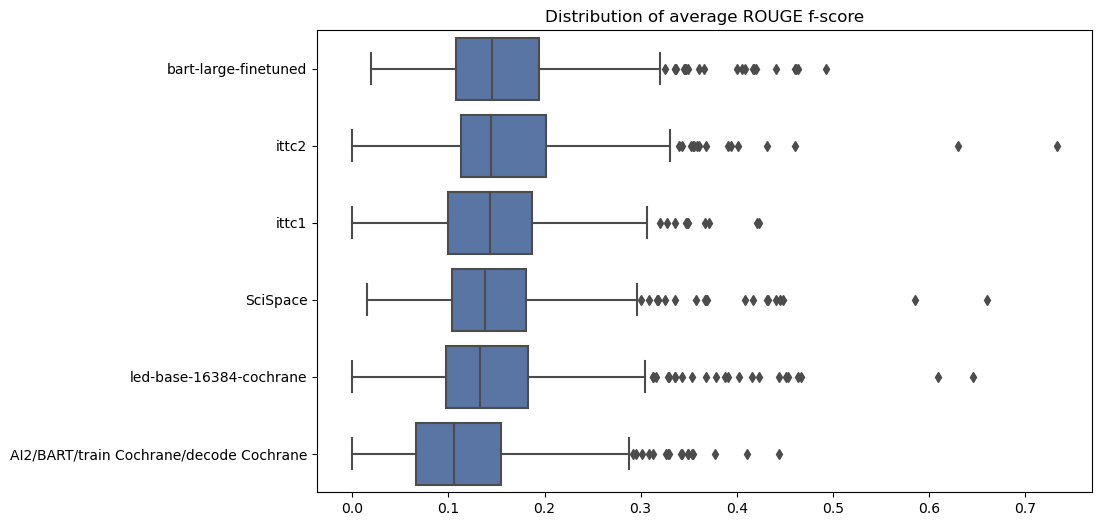

In [50]:
sns.set_color_codes()
pal = {exp: "b" for exp in df['exp_name'].unique()}

# plot these
y = "exp_name"
x = "rouge_avg_f"

# sort by median
grouped = df.groupby([y])
df2 = pd.DataFrame({col:vals[x] for col,vals in grouped})
meds = df2.median()
meds.sort_values(ascending=False, inplace=True)
df2 = df2[meds.index]

plt.figure(figsize=(10,6))
sns.boxplot(data=df2, orient='h', palette=pal)
plt.title('Distribution of average ROUGE f-score')
plt.show()

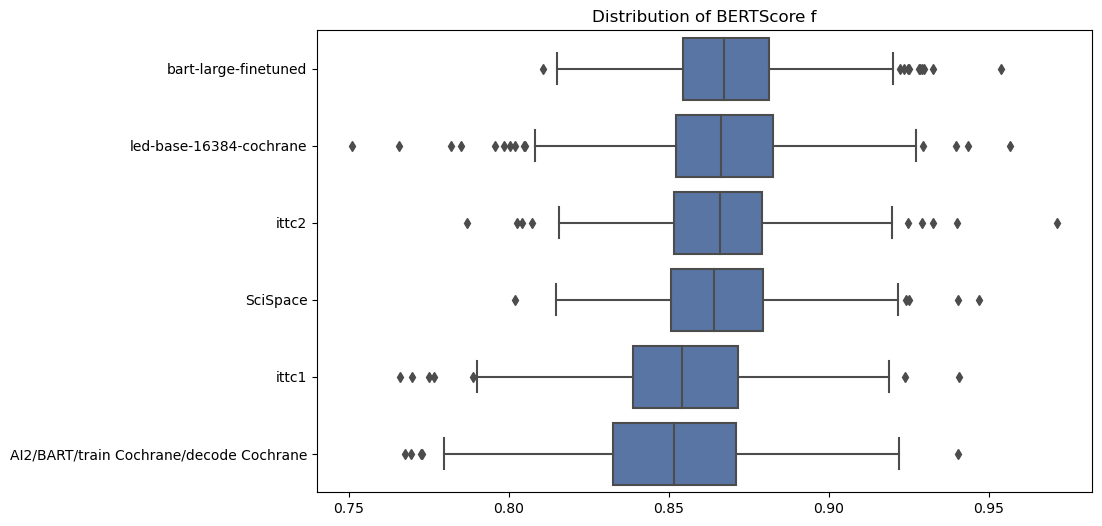

In [51]:
sns.set_color_codes()
pal = {exp: "b" for exp in df['exp_name'].unique()}

# plot these
y = "exp_name"
x = "bertscore_f"

# sort by median
grouped = df.groupby([y])
df2 = pd.DataFrame({col:vals[x] for col,vals in grouped})
meds = df2.median()
meds.sort_values(ascending=False, inplace=True)
df2 = df2[meds.index]

plt.figure(figsize=(10,6))
sns.boxplot(data=df2, orient='h', palette=pal)
plt.title('Distribution of BERTScore f')
plt.show()

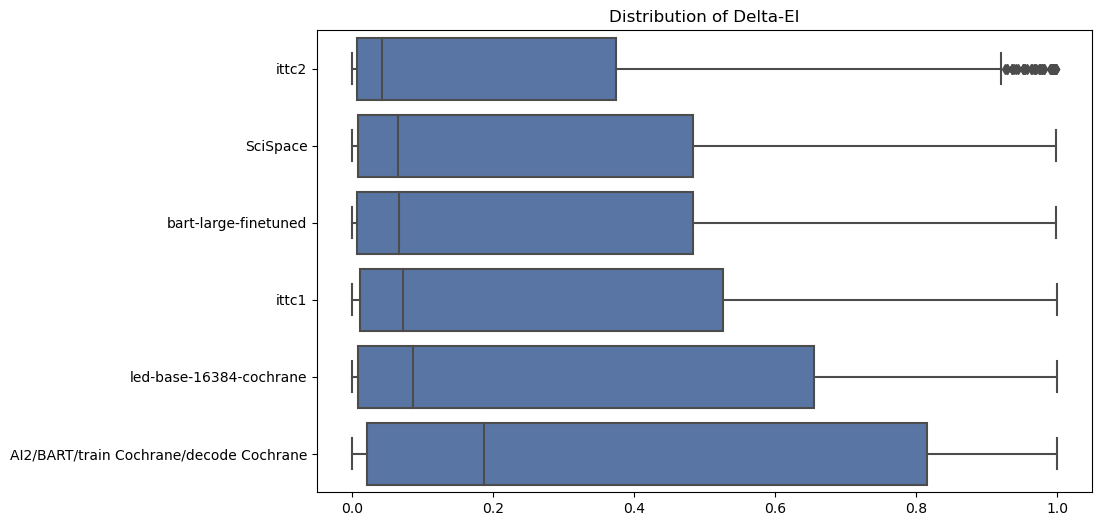

In [54]:
sns.set_color_codes()
pal = {exp: "b" for exp in df['exp_name'].unique()}

# plot these
y = "exp_name"
x = "ei_score"

# sort by median
grouped = df.groupby([y])
df2 = pd.DataFrame({col:vals[x] for col,vals in grouped})
meds = df2.median()
meds.sort_values(ascending=True, inplace=True)
df2 = df2[meds.index]

plt.figure(figsize=(10,6))
sns.boxplot(data=df2, orient='h', palette=pal)
plt.title('Distribution of Delta-EI')
plt.show()

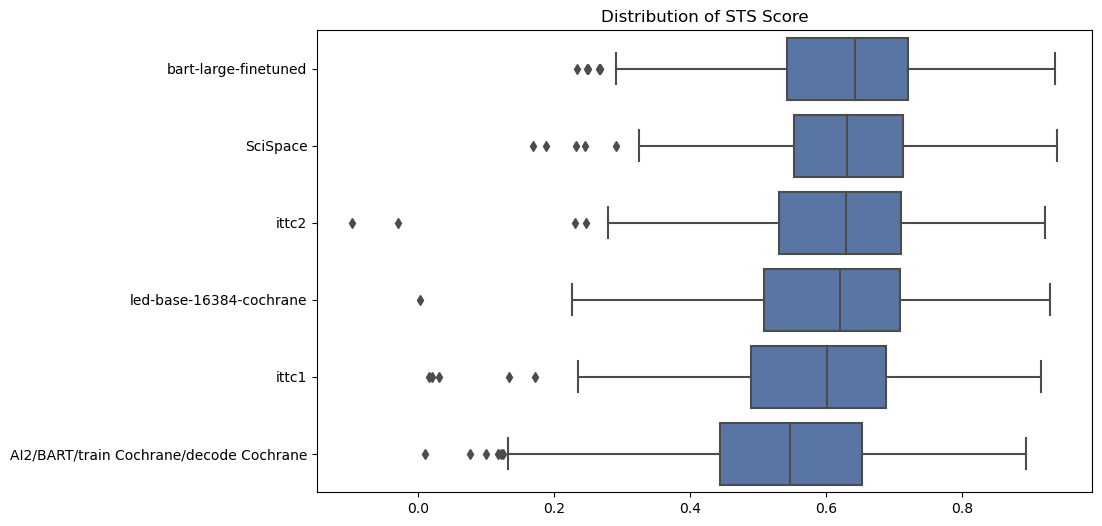

In [56]:
sns.set_color_codes()
pal = {exp: "b" for exp in df['exp_name'].unique()}

# plot these
y = "exp_name"
x = "sts"

# sort by median
grouped = df.groupby([y])
df2 = pd.DataFrame({col:vals[x] for col,vals in grouped})
meds = df2.median()
meds.sort_values(ascending=False, inplace=True)
df2 = df2[meds.index]

plt.figure(figsize=(10,6))
sns.boxplot(data=df2, orient='h', palette=pal)
plt.title('Distribution of STS Score')
plt.show()

# Correlation between metrics

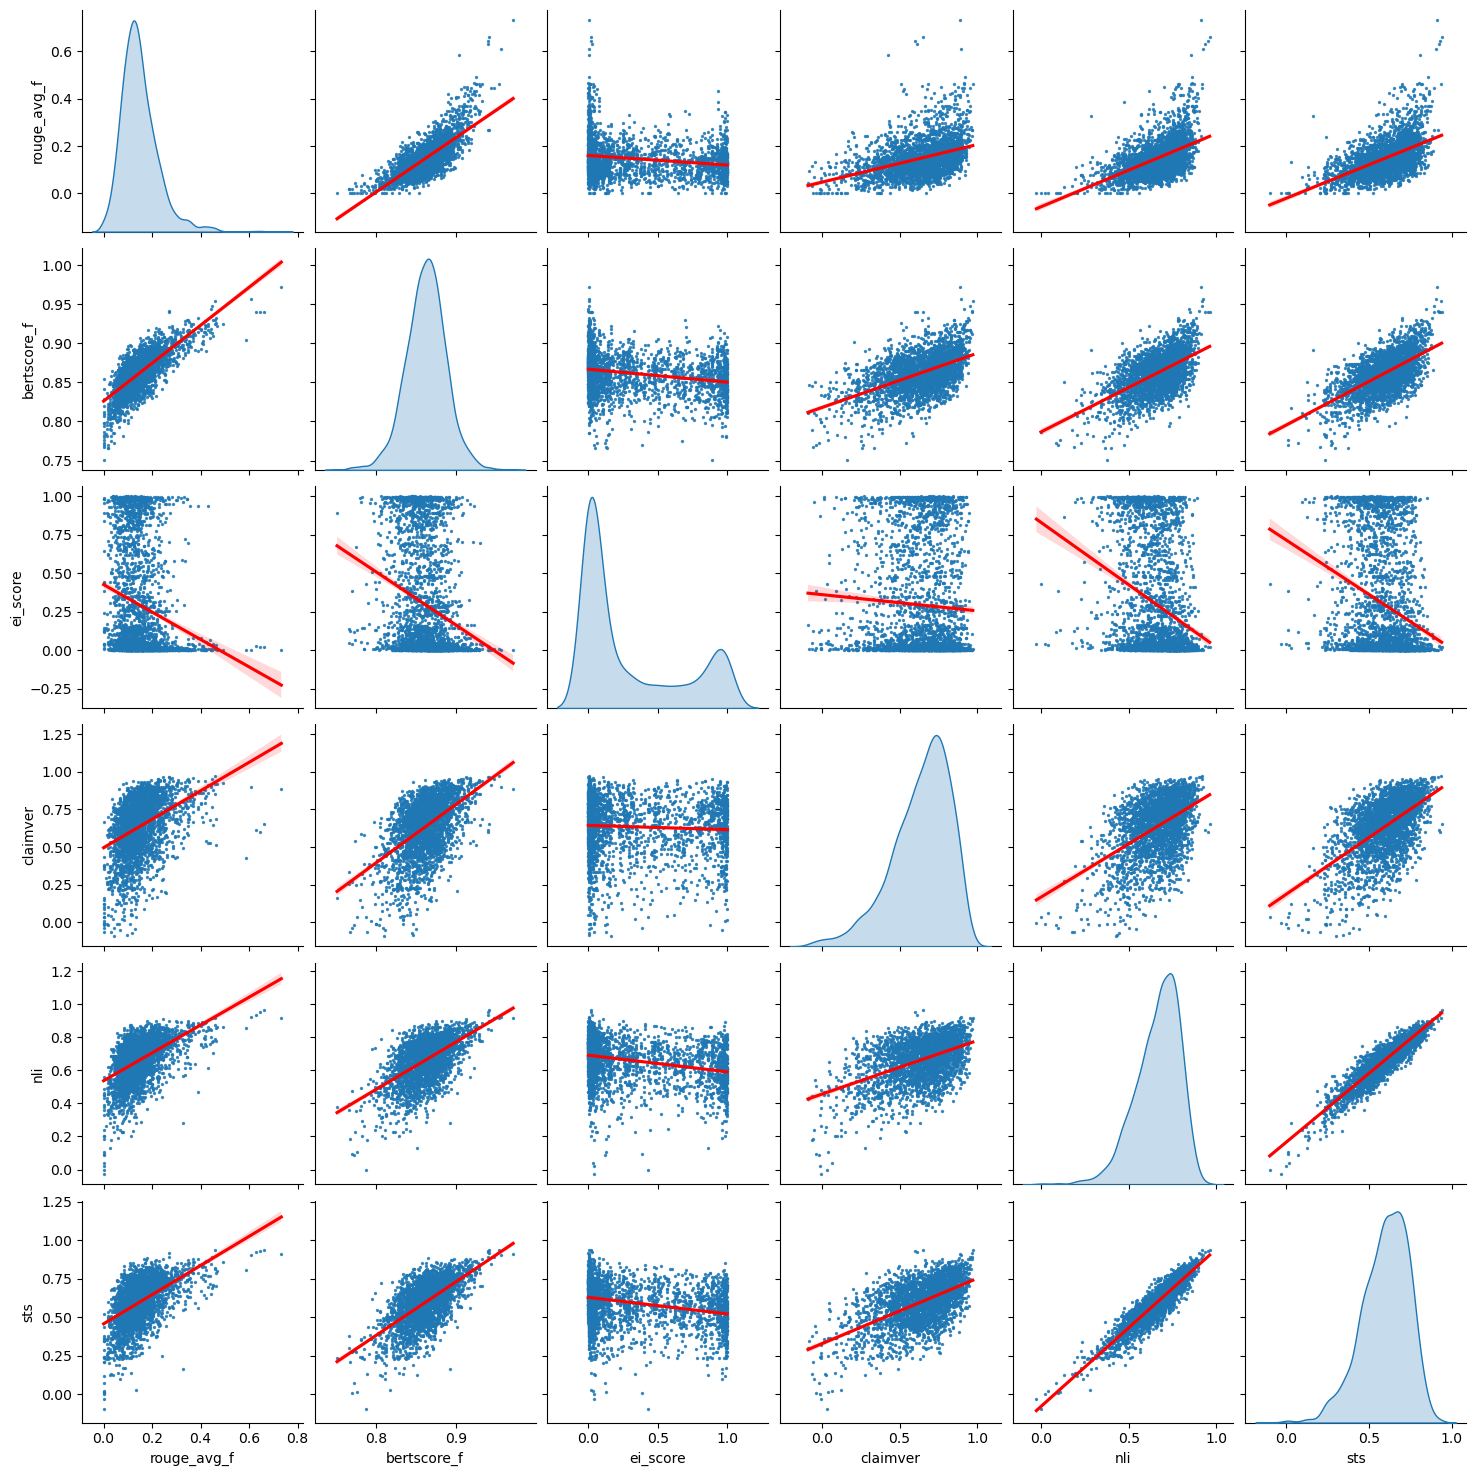

In [57]:
sns.pairplot(
    df, 
#     hue="exp_name",
    x_vars=["rouge_avg_f", "bertscore_f", "ei_score", "claimver", "nli", "sts"],
    y_vars=["rouge_avg_f", "bertscore_f", "ei_score", "claimver", "nli", "sts"],
    diag_kind="kde",
#     kind="scatter",
#     palette="muted",
    kind="reg", 
    plot_kws={
        'line_kws':{'color':'red'},
        'scatter_kws': {'s': 2}
    }
)
plt.show()

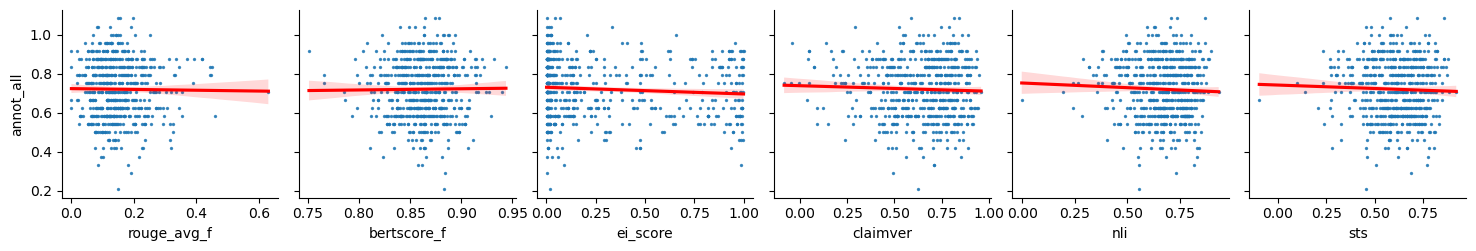

In [58]:
sns.pairplot(
    df_annot, 
#     hue="exp_name",
    diag_kind="kde",
    x_vars=["rouge_avg_f", "bertscore_f", "ei_score", "claimver", "nli", "sts"],
    y_vars=[
#         "fluency_normalized", "pio_normalized", "ed_normalized", "strength_normalized", 
        "annot_all"
    ],
#     kind="scatter",
#     palette="muted",
    kind="reg", 
    plot_kws={
        'line_kws':{'color':'red'},
        'scatter_kws': {'s': 2}
    }
)
plt.show()

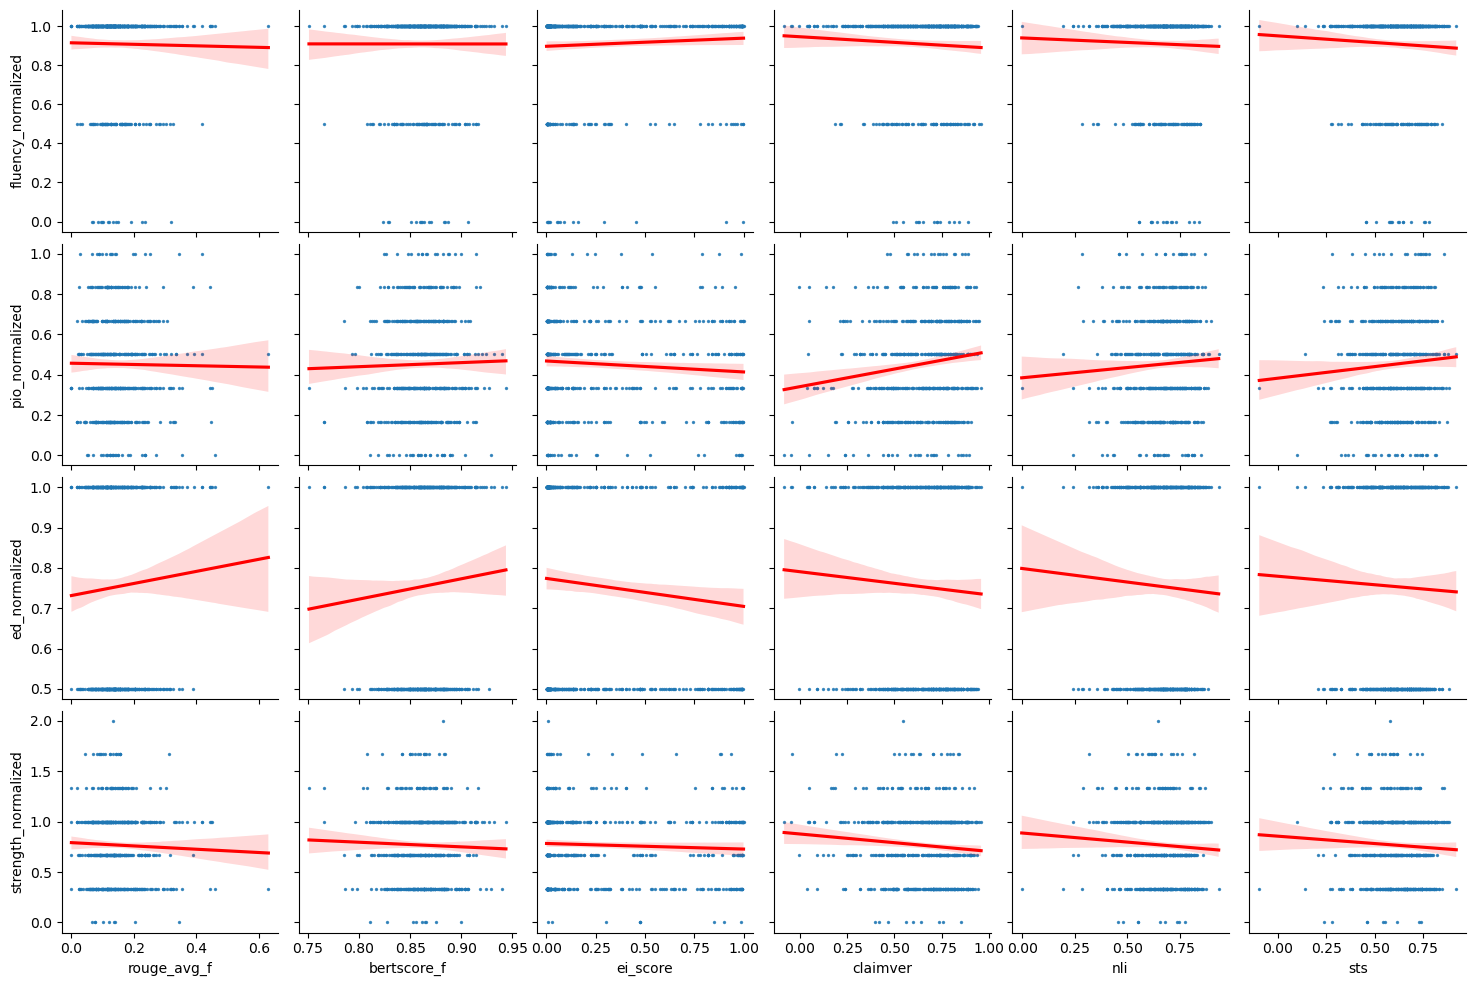

In [59]:
sns.pairplot(
    df_annot, 
#     hue="exp_name",
    x_vars=["rouge_avg_f", "bertscore_f", "ei_score", "claimver", "nli", "sts"],
    y_vars=[
        "fluency_normalized", 
        "pio_normalized", 
        "ed_normalized", 
        "strength_normalized", 
#         "annot_all"
    ],
#     kind="scatter",
#     kind="kde",
#     palette="muted"
    kind="reg", 
    plot_kws={
        'line_kws':{'color':'red'},
        'scatter_kws': {'s': 2}
    }
)
plt.show()

# System Rankings

In [60]:
score_keys = [
    'rouge_avg_f',
    'ei_score',
    'claimver',
    'nli',
    'sts'
]

annot_keys = [
    'annot_all',
    'fluency_normalized',
    'pio_normalized',
    'ed_normalized',
    'strength_normalized'
]

corr_vals = []
for score_k, annot_k in itertools.product(score_keys, annot_keys):
    p_r, p_p = pearsonr(df_annot[score_k], df_annot[annot_k])
    s_r, s_p = spearmanr(df_annot[score_k], df_annot[annot_k])
    k_t, k_p = kendalltau(df_annot[score_k], df_annot[annot_k])
    corr_vals.append({
        'score': score_k,
        'annot': annot_k,
        'p_r': p_r,
        'p_p': p_p,
        's_r': s_r,
        's_p': s_p,
        'k_t': k_t,
        'k_p': k_p
    })


In [61]:
[entry for entry in corr_vals if entry['annot'] == 'pio_normalized']

[{'score': 'rouge_avg_f',
  'annot': 'pio_normalized',
  'p_r': -0.010119213215406452,
  'p_p': 0.8051119488228281,
  's_r': -0.00959227298812815,
  's_p': 0.8150721018099445,
  'k_t': -0.00692743357252239,
  'k_p': 0.815839201222824},
 {'score': 'ei_score',
  'annot': 'pio_normalized',
  'p_r': -0.07969879199179736,
  'p_p': 0.05161358104345769,
  's_r': -0.05858782723469797,
  's_p': 0.15279203349885828,
  'k_t': -0.04295660245430153,
  'k_p': 0.14863914593940936},
 {'score': 'claimver',
  'annot': 'pio_normalized',
  'p_r': 0.1421200235117612,
  'p_p': 0.0004959802378006347,
  's_r': 0.14180151047097736,
  's_p': 0.0005107917844371906,
  'k_t': 0.10411832525208065,
  'k_p': 0.0004638091907595441},
 {'score': 'nli',
  'annot': 'pio_normalized',
  'p_r': 0.05313693335788886,
  'p_p': 0.19479614947050986,
  's_r': 0.05805860648473803,
  's_p': 0.156540825410875,
  'k_t': 0.04278203280717229,
  'k_p': 0.15029639731149633},
 {'score': 'sts',
  'annot': 'pio_normalized',
  'p_r': 0.066291

In [108]:
annot_order = df_annot.groupby(by=["exp_id"])["annot_all"].mean().sort_values(ascending=False)
pio_order = df_annot.groupby(by=["exp_id"])["pio_normalized"].mean().sort_values(ascending=False)
rouge_order = df_annot.groupby(by=["exp_id"])["rouge_avg_f"].mean().sort_values(ascending=False)
eid_order = df_annot.groupby(by=["exp_id"])["ei_score"].mean().sort_values(ascending=True)

# for a, p, r, e in zip(annot_order, pio_order, rouge_order, eid_order):
#     print(a, p, r, e)
print(annot_order)
print(pio_order)
print(rouge_order)
print(eid_order)




exp_id
SPNXTA    0.797917
VNCH8M    0.776250
AQ85CE    0.749150
PX7SGV    0.693333
JB6Z8F    0.687917
8FWF5T    0.616582
Name: annot_all, dtype: float64
exp_id
VNCH8M    0.516667
SPNXTA    0.483333
PX7SGV    0.440000
JB6Z8F    0.433333
AQ85CE    0.423469
8FWF5T    0.412458
Name: pio_normalized, dtype: float64
exp_id
JB6Z8F    0.167245
8FWF5T    0.159802
AQ85CE    0.152054
SPNXTA    0.146111
VNCH8M    0.144164
PX7SGV    0.126785
Name: rouge_avg_f, dtype: float64
exp_id
JB6Z8F    0.207814
AQ85CE    0.244611
8FWF5T    0.251985
VNCH8M    0.283077
SPNXTA    0.320848
PX7SGV    0.427931
Name: ei_score, dtype: float64


In [102]:
# pairwise annotations
exp_ids_in_order = sorted(list(EXP_W_ANNOTS))

def tally_entries(entries):
    tallies = {exp_id: {exp_id2: 0 for exp_id2 in EXP_W_ANNOTS} for exp_id in EXP_W_ANNOTS}
    sums = {exp_id: {exp_id2: 0 for exp_id2 in EXP_W_ANNOTS} for exp_id in EXP_W_ANNOTS}
    for entry in entries:
        a = entry['sys_a']
        b = entry['sys_b']
        pref = entry['choice']
        if pref == 'A':
            tallies[a][b] += 1
        elif pref == 'B':
            tallies[b][a] += 1
        if b > a:
            sums[a][b] += 1
        elif a > b:
            sums[b][a] += 1
        else:
            print('Error!!!')
    
    inferred_pref_count = {exp_id: [] for exp_id in EXP_W_ANNOTS}
    inferred_pref_sys = {exp_id: [] for exp_id in EXP_W_ANNOTS}
    
    for s1 in exp_ids_in_order:
        for s2 in exp_ids_in_order:
            if s1 == s2:
                continue
            elif s2 < s1:
                continue
            else:
                inferred_pref_count[s1].append(tallies[s1][s2])
                inferred_pref_count[s2].append(tallies[s2][s1])
                if tallies[s1][s2] > tallies[s2][s1]:
                    inferred_pref_sys[s1].append(1)
                elif tallies[s2][s1] > tallies[s1][s2]:
                    inferred_pref_sys[s2].append(1)
                    
    pref_count = {k: sum(v) for k, v in inferred_pref_count.items()}
    
    pref_sys = [(k, sum(v)) for k, v in inferred_pref_sys.items()]
    pref_sys.sort(key = lambda x: x[1], reverse = True)
        
    return pref_count, pref_sys       

inferred_preferences_counts = dict()
inferred_preferences_sys = dict()
for annotator, annot_entries in pw_annots.items():
    pref_count, pref_sys = tally_entries(annot_entries)
    inferred_preferences_counts[annotator] = pref_count
    inferred_preferences_sys[annotator] = pref_sys
    


In [123]:
# reverse to get actual ranks
new_rank_dict = dict()
for annotator, ranks in inferred_preferences_sys.items():
    rank_num = 1
    actual_ranks = []
    previous_rank = None
    buffer = 1
    for sys, score in ranks:
        if (not previous_rank):
            pass
        elif score == previous_rank:
            buffer +=1
        else:
            rank_num += buffer
            buffer = 1
        actual_ranks.append((sys, rank_num))
        previous_rank = score
    new_rank_dict[annotator] = actual_ranks
    
for annotator, ranks in new_rank_dict.items():
    print(annotator)
    print(ranks)

lucy
[('VNCH8M', 1), ('SPNXTA', 2), ('JB6Z8F', 2), ('AQ85CE', 4), ('PX7SGV', 4), ('8FWF5T', 6)]
jay
[('VNCH8M', 1), ('SPNXTA', 1), ('AQ85CE', 3), ('JB6Z8F', 4), ('PX7SGV', 4), ('8FWF5T', 6)]
thinh
[('JB6Z8F', 1), ('AQ85CE', 2), ('PX7SGV', 2), ('VNCH8M', 4), ('8FWF5T', 4), ('SPNXTA', 6)]
yulia
[('AQ85CE', 1), ('VNCH8M', 1), ('JB6Z8F', 1), ('8FWF5T', 4), ('SPNXTA', 5), ('PX7SGV', 6)]
byron
[('VNCH8M', 1), ('SPNXTA', 2), ('AQ85CE', 3), ('JB6Z8F', 4), ('8FWF5T', 5), ('PX7SGV', 5)]


In [129]:
total_score = {exp_id: 0 for exp_id in EXP_W_ANNOTS}

for annotator, ranks in new_rank_dict.items():
    for sys_id, rank in ranks:
        num_points = sum([1 for _, i in ranks if i > rank])
        total_score[sys_id] += num_points
        
best_sys = [(k, v) for k, v in total_score.items()]
best_sys.sort(key=lambda x: x[1], reverse=True)

print('Rank order by pairwise preferences')
print()
print('rank\tpoints\tsys_id\tsys_name')
print('-----------------------------------------')
for i, (k, v) in enumerate(best_sys):
    print(f'{i+1}\t{v}\t{k}\t{submissions[k]["name"]}')


Rank order by pairwise preferences

rank	points	sys_id	sys_name
-----------------------------------------
1	18	VNCH8M	ittc1
2	14	JB6Z8F	ittc2
3	13	AQ85CE	bart-large-finetuned
4	12	SPNXTA	led-base-16384-cochrane
5	5	PX7SGV	AI2/BART/train Cochrane/decode Cochrane
6	3	8FWF5T	SciSpace


In [130]:
facet_best_sys = list(annot_order.items())

print('Rank order by aggregate facet annotation score')
print()
print('rank\tscore\tsys_id\tsys_name')
print('-----------------------------------------')
for i, (k, v) in enumerate(facet_best_sys):
    print(f'{i+1}\t{v:.3f}\t{k}\t{submissions[k]["name"]}')

Rank order by aggregate facet annotation score

rank	score	sys_id	sys_name
-----------------------------------------
1	0.798	SPNXTA	led-base-16384-cochrane
2	0.776	VNCH8M	ittc1
3	0.749	AQ85CE	bart-large-finetuned
4	0.693	PX7SGV	AI2/BART/train Cochrane/decode Cochrane
5	0.688	JB6Z8F	ittc2
6	0.617	8FWF5T	SciSpace


<AxesSubplot:>

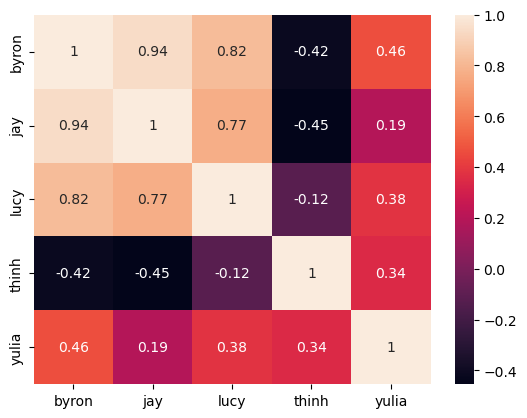

In [157]:
# Spearman rank tests between annotators (Pairwise annotation rankings)
sys_list = list(EXP_W_ANNOTS)
spearman_coeffs = dict()
for ann1, ann2 in itertools.product(new_rank_dict, new_rank_dict):
    ann1_ranks = [i[1] for i in sorted(new_rank_dict[ann1], key=lambda x: sys_list.index(x[0]))]
    ann2_ranks = [i[1] for i in sorted(new_rank_dict[ann2], key=lambda x: sys_list.index(x[0]))]
    res = spearmanr(ann1_ranks, ann2_ranks)
    spearman_coeffs[(ann1, ann2)] = res

ser = pd.Series([res.correlation for res in list(spearman_coeffs.values())],
    index=pd.MultiIndex.from_tuples(spearman_coeffs.keys()))
df = ser.unstack().fillna(0)

sns.heatmap(df, annot=True)


In [156]:
# Spearman correlation coefficient between each individual pairwise annotator and the ranking from the global vote tally
sys_list = list(EXP_W_ANNOTS)
global_spearman_coeffs = dict()
global_best_sys = [(entry[0], i+1) for i, entry in enumerate(best_sys)]
global_ranks = [i[1] for i in sorted(global_best_sys, key=lambda x: sys_list.index(x[0]))]
for ann, ranks in new_rank_dict.items():
    ann_ranks = [i[1] for i in sorted(new_rank_dict[ann], key=lambda x: sys_list.index(x[0]))]
    res = spearmanr(global_ranks, ann_ranks)
    global_spearman_coeffs[ann] = res
  
print('Annotator\tSpearman R\tp-value')
print('---------------------------------------')
for ann, res in global_spearman_coeffs.items():
    print(f'{ann}\t\t{res.correlation:.3f}\t\t{res.pvalue:.3f}')



Annotator	Spearman R	p-value
---------------------------------------
lucy		0.853		0.031
jay		0.618		0.191
thinh		0.235		0.653
yulia		0.759		0.080
byron		0.754		0.084


In [ ]:
# all rankings by automated metrics and human eval scores
